In [5]:
import itertools
import operator
import sys
import os
import numpy as np
from tqdm.notebook import tqdm
sys.path.append("../src")
from glob import glob
import pandas as pd
import json
from matplotlib import pyplot as plt

In [6]:
search_root = "/checkpoint/jth/job_staging/neuraldb_expts/experiment=operator"
checkpoint_name = "metrics_test.jsonl"
files = glob("{}/**/{}".format(search_root,checkpoint_name), recursive=True)


print(len(files))

57


In [13]:
def expand(idx,chunk):
  #elif idx == 1:
  #  return ["experiment={}".format(chunk)]
  if chunk.startswith("seed-"):
    return ["seed={}".format(chunk.replace("seed-",""))]
  elif "," in chunk:
    return chunk.split(",")
  elif "=" in chunk:
    return [chunk]

  return []

experiments = []
for file in files:
    chunks = file.split("/")
    chunks = itertools.chain(*[expand(idx, chunk) for idx, chunk in enumerate(chunks)])

    data = {k:v for k,v in (chunk.split("=") for chunk in chunks)}
    data["file"] = file
    data['dir'] = os.path.dirname(file)
    data["train_percentage"] = float(data["train_percentage"])*100 if data["train_percentage"] != "null" else 100.0


    if data["version"].startswith("v1.2"):
        experiments.append(data)

In [14]:
from collections import defaultdict


for experiment in tqdm(experiments):
    all_raw = []
    all_breakdown = defaultdict(dict)
    em = 0.0
    with open(experiment['file']) as f:
        for line in f:
            partial_results = json.loads(line)
            all_raw.extend(partial_results['test']['raw'])
            all_breakdown["breakdown_prop"].update(partial_results['test']['breakdown']["breakdown_prop"].items())
            all_breakdown["breakdown_type"].update(partial_results['test']['breakdown']["breakdown_type"].items())


    experiment["EM"] = np.mean([rec[2] for rec in all_raw])

    for k,v in all_breakdown["breakdown_prop"].items():
        experiment["prop_{}".format(k)] = np.mean(v)

    for k,v in all_breakdown["breakdown_type"].items():
        experiment["type_{}".format(k)] = np.mean(v)
        experiment["count_type_{}".format(k)] = len(v)


    experiment["raw"] = all_raw

    avg = []
    for k,v in experiment.items():
        if k.startswith("type_negative"):
            avg.append((experiment["count_{}".format(k)], v))

    support, ems = zip(*avg)
    experiment["x_avg_negative"] = np.average(a=ems,weights=support)

In [15]:
results = pd.DataFrame(experiments).fillna(0)
#results = results[results["version"]=="v1.1.1"]
cols = {col:[np.mean, np.std] for col in filter(lambda col: col == "EM" or col.startswith("x_") or col.startswith("prop_") or col.startswith("type_"),results.columns)}
cols.update({col:[np.max] for col in filter(lambda col: col.startswith("count_type_negative"), results.columns)})
breakdown_cols = list(filter(lambda col: col.startswith("prop_"),results.columns))
type_cols = list(filter(lambda col: col.startswith("type_") and "negative" not in col,results.columns))
print(type_cols)
type_cols2 = list(filter(lambda col: col.startswith("type_") and "negative" not in col or col == "x_avg_negative",results.columns))
type_cols3 = list(filter(lambda col: "count" not in col and  "negative" in col,results.columns))
type_cols4 = list(filter(lambda col: col.startswith("type_") and "negative" not in col,results.columns))
breakdown = pd.pivot_table(results, index=["experiment","version","model","lr","filters","train_percentage"],columns=[],aggfunc=cols)
breakdown

['type_count', 'type_argmin', 'type_bool', 'type_argmax', 'type_set']


EM  \
                                                                       mean   
experiment version          model   lr   filters train_percentage             
operator   v1.2_resolv_100k t5-base 8e-3 null    10.0              0.973922   
                                                 50.0              0.883152   
                                                 100.0             0.322247   
                                    8e-4 null    10.0              0.979011   
                                                 50.0              0.979875   
                                                 100.0             0.979340   
                                    8e-5 null    10.0              0.975753   
                                                 50.0              0.979325   
                                                 100.0             0.979764   
                                    8e-6 null    10.0              0.945998   
                                                 50.0              0.973495   
                                                 100.0             0.976149   

                                                                             \
                                                                        std   
experiment version          model   lr   filters train_percentage             
operator   v1.2_resolv_100k t5-base 8e-3 null    10.0              0.000303   
                                                 50.0              0.038796   
                                                 100.0             0.052323   
                                    8e-4 null    10.0              0.000142   
                                                 50.0              0.000270   
                                                 100.0             0.000429   
                                    8e-5 null    10.0              0.000381   
                                                 50.0              0.000155   
                                                 100.0             0.000162   
                                    8e-6 null    10.0              0.000285   
                                                 50.0              0.000117   
                                                 100.0             0.000089   

                                                                  count_type_negative(argmax,argmax)  \
                                                                                                amax   
experiment version          model   lr   filters train_percentage                                      
operator   v1.2_resolv_100k t5-base 8e-3 null    10.0                                           3067   
                                                 50.0                                           3067   
                                                 100.0                                          3067   
                                    8e-4 null    10.0                                           3067   
                                                 50.0                                           2950   
                                                 100.0                                          3067   
                                    8e-5 null    10.0                                           3067   
                                                 50.0                                           2950   
                                                 100.0                                          3067   
                                    8e-6 null    10.0                                           2950   
                                                 50.0                                           2950   
                                                 100.0                                          3067   

                                                                  count_type_negative(argmax,argmin)  \
                                    

In [16]:
display = "v1.2_resolv_100k"

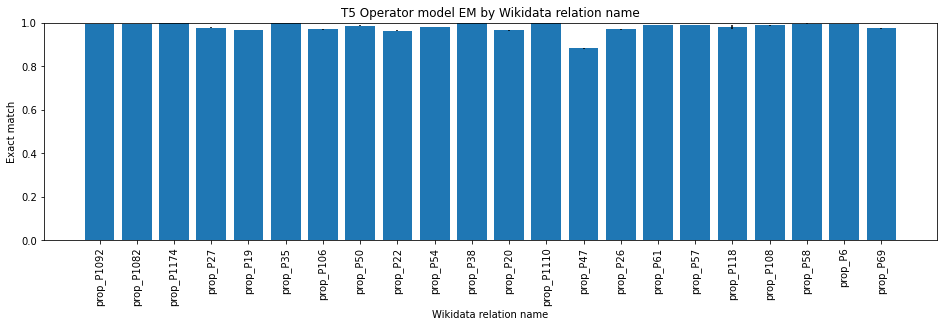

In [20]:

prop_scores = breakdown.T["operator"][display]["t5-base"]["8e-5"]["null"][100.0].T[breakdown_cols]

means = []
stds = []

for score in [prop_scores[a] for a in breakdown_cols]:
    means.append(score["mean"])
    stds.append(score["std"])


plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
plt.title("T5 Operator model EM by Wikidata relation name")
plt.ylabel("Exact match")
plt.xlabel("Wikidata relation name")

plt.bar(breakdown_cols,means,yerr=stds)
plt.ylim(0,1)
plt.show()


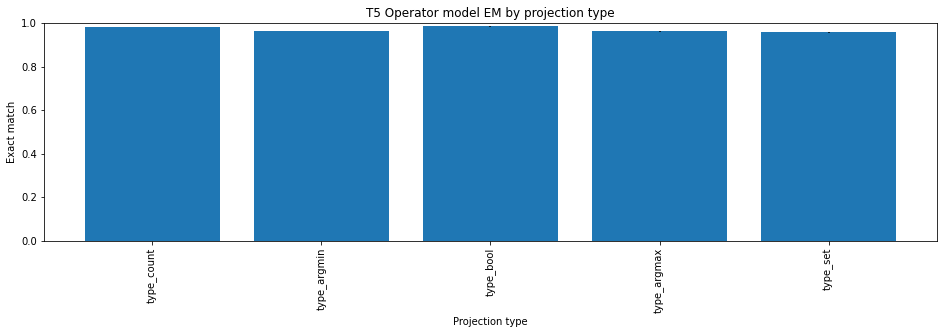

In [22]:
prop_scores = breakdown.T["operator"][display]["t5-base"]["8e-5"]["null"][100.0].T[type_cols]

means = []
stds = []

for score in [prop_scores[a] for a in type_cols]:
    means.append(score["mean"])
    stds.append(score["std"])


plt.figure(figsize=(16,4))
plt.xticks(rotation=90)

plt.title("T5 Operator model EM by projection type")
plt.ylabel("Exact match")
plt.xlabel("Projection type")
plt.bar(type_cols,means,yerr=stds)
plt.ylim(0,1)
plt.show()

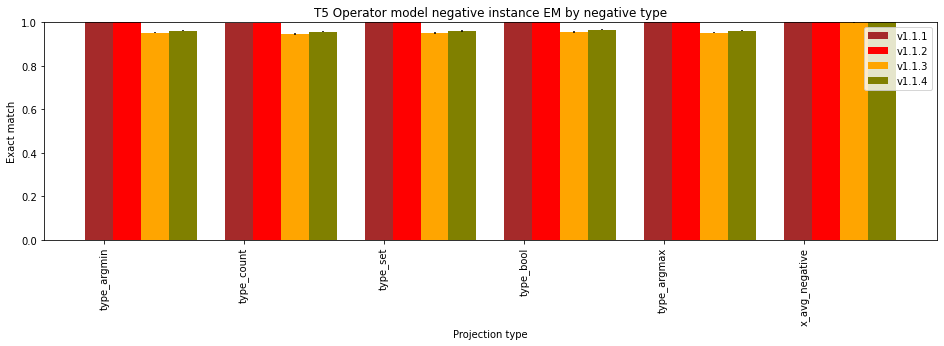

In [56]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)

plt.title("T5 Operator model EM by projection type")
plt.ylabel("Exact match")
plt.xlabel("Projection type")
plt.title("T5 Operator model negative instance EM by negative type")

x = np.arange(len(type_cols2))
w = 0.2
plt.xticks(x+w/5, type_cols2,rotation=90)

datasets = ["v1.1.1", "v1.1.2", "v1.1.3", "v1.1.4"]
colors = ["brown", "red","orange", "olive"]
for idx, display in enumerate(datasets):
    prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["null"][100.0].T[type_cols2]

    means = []
    stds = []

    for score in [prop_scores[a] for a in type_cols2]:
        means.append(score["mean"])
        stds.append(score["std"])

    plt.bar(x+idx*w,means,yerr=stds, width=w, color=colors[idx])

plt.ylim(0,1)
plt.legend(datasets)
plt.show()

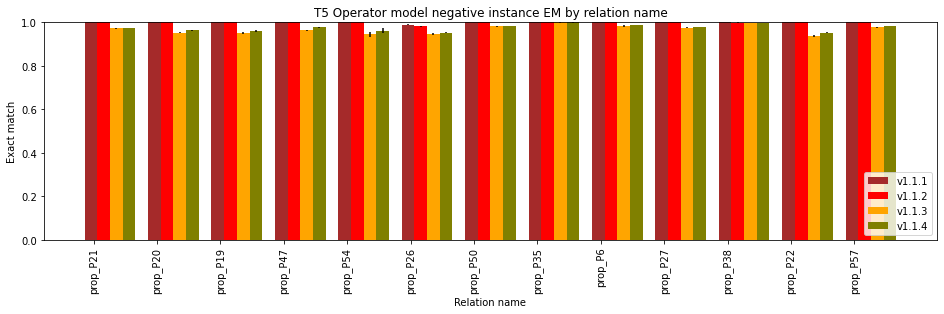

In [64]:

plt.figure(figsize=(16,4))
plt.xticks(rotation=90)

plt.title("T5 Operator model EM by relation name")
plt.ylabel("Exact match")
plt.xlabel("Relation name")
plt.title("T5 Operator model negative instance EM by relation name")

x = np.arange(len(breakdown_cols))
w = 0.2
plt.xticks(x+w/5, breakdown_cols,rotation=90)

datasets = ["v1.1.1", "v1.1.2", "v1.1.3", "v1.1.4"]
colors = ["brown", "red","orange", "olive"]
for idx, display in enumerate(datasets):
    prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["null"][100.0].T[breakdown_cols]

    means = []
    stds = []

    for score in [prop_scores[a] for a in breakdown_cols]:
        means.append(score["mean"])
        stds.append(score["std"])

    plt.bar(x+idx*w,means,yerr=stds, width=w, color=colors[idx])

plt.ylim(0,1)
plt.legend(datasets, loc='lower right')
plt.show()


In [ ]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)

plt.title("T5 Operator model EM by projection type")
plt.ylabel("Exact match")
plt.xlabel("Projection type")


prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["null"][100.0].T[type_cols2]

means = []
stds = []

for score in [prop_scores[a] for a in type_cols2]:
    means.append(score["mean"])
    stds.append(score["std"])

plt.bar(type_cols2,means,yerr=stds)

plt.ylim(0,1)
plt.show()




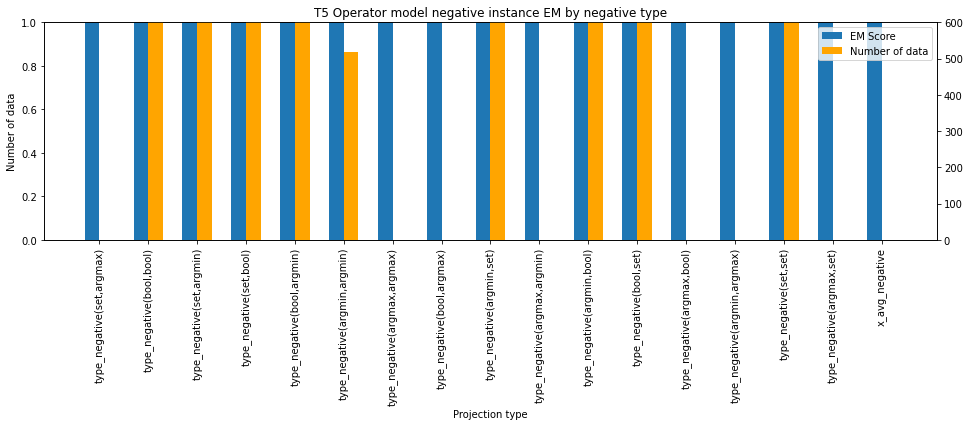

In [12]:
prop_scores = breakdown.T["operator_sweep"]["t5-base"]["null"][100.0].T[type_cols3]

means = []
stds = []
matched = []
props = []

w = 0.3
for name in type_cols3:

    try:
        score =  prop_scores[name]
        matched.append(name)
        means.append(score["mean"])
        stds.append(score["std"])

    except:
        print("No instances for {}".format(name))

    if "x" not in name:
        props.append(breakdown.T["operator_sweep"]["t5-base"]["null"][100.0]["count_{}".format(name)]["amax"])
    else:
        props.append(0.0)


fig,ax1 = plt.subplots(figsize=(16,4))

x = np.arange(len(matched))

plt.xticks(x+w/2, matched,rotation=90)
plt.title("T5 Operator model negative instance EM by negative type")
ax1.set_ylabel("Exact match")
ax1.set_xlabel("Projection type")

ems = ax1.bar(x, means, yerr=stds, width=w)

ax2 = plt.twinx()
sizes = ax2.bar(x+w, props, color="orange", width=w)
ax1.set_ylabel("Number of data")

plt.legend([ems,sizes],['EM Score','Number of data'])
ax1.set_ylim(0,1)
ax2.set_ylim(0,600)
plt.show()

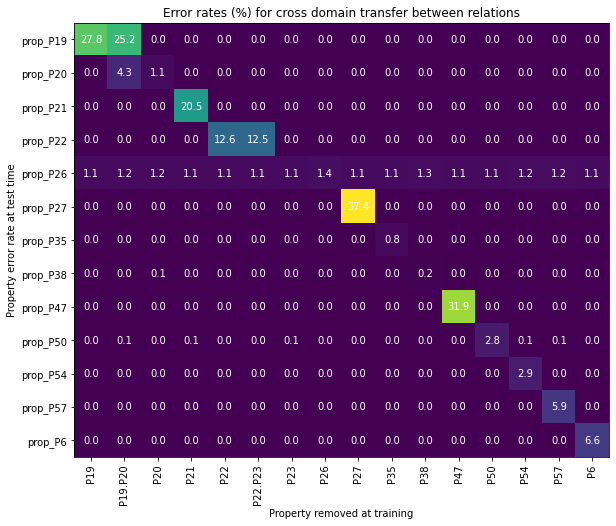

In [40]:
breakdown_cols= list(breakdown_cols)
cols2 = list(set(map(lambda a: a[0], filter(lambda col:col[0] != "null", breakdown.T["operator_filter"]["v1.1.1"]["t5-base"].columns))))

x_labels = sorted(cols2)
y_labels = sorted(breakdown_cols)

heatmap = []

for c in y_labels:
    row = []
    for x in x_labels:
        row.append(breakdown.T["operator_filter"]["v1.1.1"]["t5-base"][x][100.0].T[c]["mean"])
    heatmap.append(row)

heatmap=np.array(heatmap)

assert heatmap.shape[0] == len(y_labels)
assert heatmap.shape[1] == len(x_labels)

fig, ax = plt.subplots(figsize=(8,12))
im = ax.imshow(1-heatmap)

fig.tight_layout()
plt.xticks(np.arange(len(x_labels)),x_labels,rotation=90)
plt.yticks(np.arange(len(y_labels)),y_labels)

for j in range(len(x_labels)):
    for i in range(len(y_labels)):
        text = ax.text(j,i, round(100*(1-heatmap[i,j]),1),color='w', ha="center",va="center")


plt.xlabel("Property removed at training")
plt.ylabel("Property error rate at test time")
plt.title("Error rates (%) for cross domain transfer between relations")
plt.show()


In [23]:
sizes = [a[3] for a in breakdown.index if a[2] == "null" and a[3] != "null"]



prop_scores = breakdown.T["operator_sweep"]["t5-base"]["null"][sizes].T["EM"]

means = []
uppers = []
lowers = []

for mean,std in [(prop_scores["mean"][size],prop_scores["std"][size]) for size in sizes]:
    means.append(mean)
    lowers.append(mean-std)
    uppers.append(mean-std)


plt.figure(figsize=(16,4))
print(sizes)
actual = [739788*size for size in sizes]
plt.title("T5 Operator model EM by training data ablation")
plt.ylabel("Exact match")
plt.xlabel("Number of training data")
plt.plot(actual,means)
plt.xscale("log")
plt.fill_between(actual,lowers,uppers,alpha=0.2)


legend = ["All"]
for line in type_cols2:
    prop_scores = breakdown.T["operator_sweep"]["t5-base"]["null"][sizes].T[line]

    means = []
    uppers = []
    lowers = []

    for mean,std in [(prop_scores["mean"][size],prop_scores["std"][size]) for size in sizes]:
        means.append(mean)
        lowers.append(mean-std)
        uppers.append(mean-std)

    plt.plot(actual,means)
    plt.fill_between(actual,lowers,uppers,alpha=0.2)
    legend.append(line)


plt.legend(legend)
plt.show()

KeyError: 'operator_sweep'

In [19]:
def get_num(item):
    bits = item.split("[SEP]")
    if len(bits) > 1:
        return bits[1].strip()
    else:
        return None

def get_ent(item):
    bits = item.split("[SEP]")
    if len(bits) > 1:
        return bits[0].strip().replace("[LOOKUP]","").strip()
    else:
        return None

err_predict_null =0
err_wrong_num = 0
err_wrong_ent = 0

for exp in filter(lambda exp: "filters=null,train_percentage=1.0" in exp["file"], experiments):
    for item in exp["raw"]:
        if "[SEP]" in item[0]:
            master = get_num(item[0])
            predicted = get_num(item[1])

            if predicted is None:
                err_predict_null += 1

            elif predicted != master:
                err_wrong_num += 1

                print(predicted,master)

        if "[SEP]" in item[0]:
            master = get_ent(item[0])
            predicted = get_ent(item[1])

            if predicted is None:
                pass
            elif predicted != master:
                err_wrong_num += 1
                print(predicted,master)


print(err_wrong_num, err_predict_null)

Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Spanish real Viceroyalty of the Ro de la Plata
[ARG] Viceroyalty of the Ro de la Plata [ARG] Spanish real
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
[ARG] Molly Moon's Incredible Book of Hypnotism [ARG] Molly Moon
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel Lauenburg
Köthel Lauenburg) Köthel

In [7]:
from collections import defaultdict
full = list(filter(lambda file: "filters=null,train_percentage=1.0" in file and "v1.0.1" in file, files))

print("FALSE NEGATIVES")
type_counts = defaultdict(int)
for exp in filter(lambda exp: "filters=null,train_percentage=1.0" in exp["file"] and "v1.1.4" in file, experiments):
    for item in exp["raw"]:
    # for item in random.sample(exp["raw"],k=100):
        if "[NULL_ANSWER]" in item[0] and item[2]<1:
            test_instance = item[3]
            type_counts[test_instance["type"]] +=1
            #print("*"*80)
            #print("Score\t\t",item[2])
            #print("Query\t\t",item[3]["query"])
            #print("Fact\t\t",item[3]["fact"])
            #print("Projection\t\t",item[3]["projection"])
            ##print("Projection (tokenized)\t\t", item[1])
            #print("Predicted (tokenized)\t\t", item[0])

print(type_counts)

FALSE NEGATIVES
defaultdict(<class 'int'>, {})


In [6]:
import random
from collections import defaultdict
full = list(filter(lambda file: "filters=null,train_percentage=1.0" in file and "v1.0.1" in file, files))

print("FALSE POSITIVES")
type_counts = defaultdict(int)
for exp in filter(lambda exp: "filters=null,train_percentage=1.0" in exp["file"] and "v1.1.4" in exp["file"], experiments):
    for item in random.sample(exp["raw"],k=100):
        if "[NULL_ANSWER]" in item[1] and item[2]<1:
            test_instance = item[3]
            type_counts[test_instance["type"]] +=1
            print("*"*80)
            print("Score\t\t",item[2])
            print("Query\t\t",item[3]["query"])
            print("Type\t\t",item[3]["type"])
            print("Fact\t\t",item[3]["fact"])
            print("Projection\t\t",item[3]["projection"])
            print("Projection (tokenized)\t\t", item[1])
            print("Predicted (tokenized)\t\t", item[0])
            break


print(type_counts)

FALSE POSITIVES
defaultdict(<class 'int'>, {})


In [1]:
import random
from collections import defaultdict

print("TRANS ERROR")
type_counts = defaultdict(int)
for exp in filter(lambda exp: "filters=null,train_percentage=1.0" in exp["file"] and "v1.1.4" in exp["file"], experiments):
    for item in exp["raw"]:
        if item[1]!= "[NULL_ANSWER]" and item[0] != "[NULL_ANSWER]" and item[2]<1:
            test_instance = item[3]
            type_counts[test_instance["type"]] +=1
            print("*"*80)
            print("Score\t\t",item[2])
            print("Query\t\t",item[3]["query"])
            print("Type\t\t",item[3]["type"])
            print("Fact\t\t",item[3]["fact"])
            print("Projection\t\t",item[3]["projection"])
            print("Projection (tokenized)\t\t", item[1])
            print("Actual (tokenized)\t\t", item[0])
            break

    break

print(type_counts)


TRANS ERROR


NameError: name 'experiments' is not defined